In [1]:
# HIDDEN
Base.displaysize() = (5, 80)
using DataFrames
using CSV

## Visualizing Qualitative Data

For qualitative or categorical data, we most often use bar charts and dot charts. We will show how to create these plots using `StatsPlots` and the Titanic survivors dataset.

In [3]:
# Import StatsPlots
using StatsPlots

# Load the dataset and skip missing data
ti = CSV.read("data/titanic.csv", ignoreemptylines=true)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who
,Int64,Int64,String,Float64,Int64,Int64,Float64,String,String,String
1,1,1,female,38.0,1,0,71.2833,C,First,woman
2,1,1,female,35.0,1,0,53.1,S,First,woman
3,0,1,male,54.0,0,0,51.8625,S,First,man
4,1,3,female,4.0,1,1,16.7,S,Third,child
5,1,1,female,58.0,0,0,26.55,S,First,woman
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


### Recipes

Recipes allows us to define our own visualizations without having to rely on `Plots`. This means we can define a type of plot that isn't readily available on any plotting backend. This feature is specially useful when plotting categorical data, for example.

For more information on recipes, check the [documentation](https://docs.juliaplots.org/latest/recipes/). We will start with an example ofa custom bar plot function:

### Bar Charts

We'll use `countmap` to count the occurrencies of each category, and create our custom bar plot recipe `countplot`:

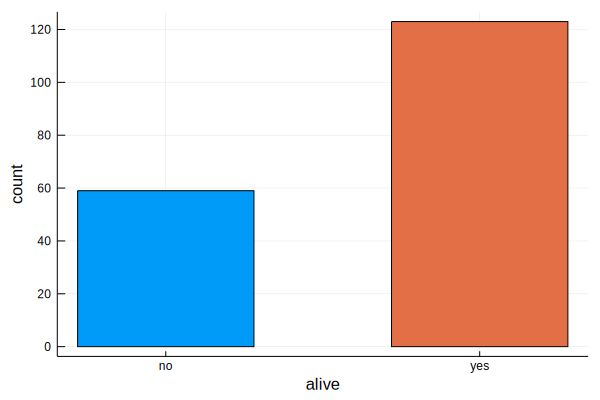

In [55]:
using StatsBase
@userplot CountPlot
@recipe function f(cp::CountPlot)
    arr = cp.args[1]
    
    seriestype := :bar
    legend := false
    ylabel := "count"
    cm = countmap(arr)
    x = collect(keys(cm))
    y = collect(values(cm))
    x, y
end

groups = collect(keys(countmap(ti.alive)))
countplot(ti.alive, group=groups, xlabel="alive")

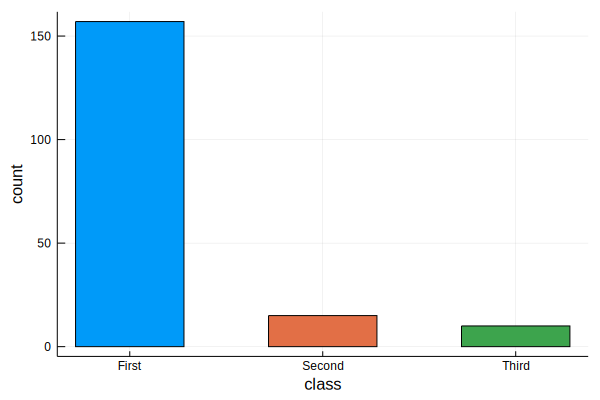

In [56]:
groups = collect(keys(countmap(ti.class)))
countplot(ti.class, group=groups, xlabel="class")

The [`groupedbar`](https://github.com/JuliaPlots/StatsPlots.jl#grouped-bar-plots) method from `StatsPlots` allows us to further break a category:

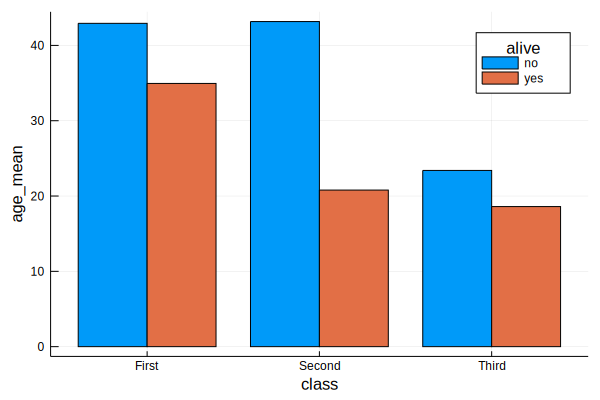

In [66]:
ti_age_means = by(ti, [:alive, :class], :age => mean)

@df ti_age_means groupedbar(:class, :age_mean, group=:alive, legendtitle="alive")
xlabel!("class")
ylabel!("age_mean")

### Dot Charts

Dot charts are similar to bar charts. Instead of plotting bars, dot charts mark a single point at the end of where a bar would go, and marking 95% confidence intervals as vertical lines cetered on each point. `Plots` doesn't support dot charts, so we'll create a custom recipe. For that, we'll pass the categorical column to be grouped by, and the column to which we want to visualize the mean. We'll use `confint` from [`HypothesisTests`](https://github.com/JuliaStats/HypothesisTests.jl) to calculate the confidence interval:

In [122]:
using HypothesisTests

@userplot PointPlot
@recipe function f(cp::PointPlot)
    df = cp.args[1]
    cat = cp.args[2]
    num = cp.args[3]
    #ci = cp.args[4]
    
    grouped_df = by(df, cat, num => mean, num => x-> confint(OneSampleTTest(x)))
    sort!(grouped_df, cat)
    
    legend := false
    color := :blue
    linewidth := 2
    
    @series begin
        seriestype := :scatter
        x = grouped_df[:, 1]
        y = grouped_df[:, 2]
        x, y
    end
    
    @series begin
        seriestype := :line
        x = grouped_df[:, 1]
        y = grouped_df[:, 2]
        x, y
    end
    
    for row in eachrow(grouped_df)
        @series begin
           seriestype := :line
            x = repeat([row[1]], inner=2)
            y = [ci for ci in row[3]]
            x,y
        end
    end
    
end;

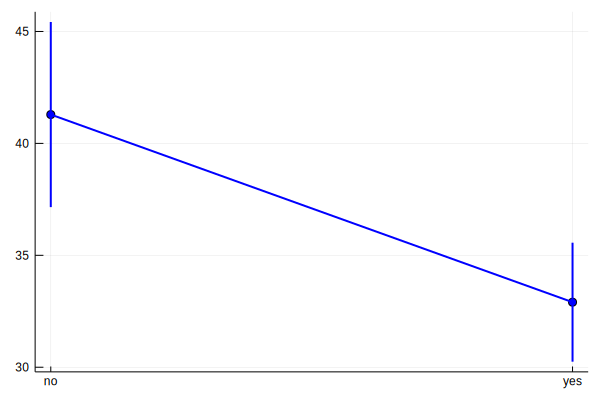

In [123]:
# For each set of alive/not alive passenger, compute and plot the average age.
pointplot(ti, :alive, :age)

Dot charts are most useful when comparing changes across categories:

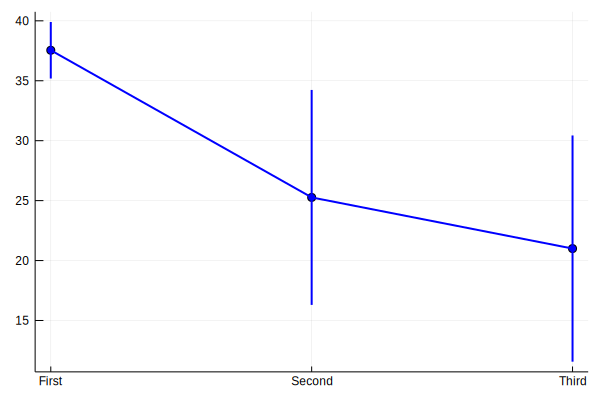

In [124]:
# Shows the proportion of survivors for each passenger class
pointplot(ti, :class, :age)